In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import norm
from scipy.linalg import lu, solve_triangular
from sympy import atan, sin, acos, cos, Matrix
from sympy.abc import rho, phi

Initially, we established the $f(\theta,\phi)=(x,y)$ function for the position of the robots arm, depending on the respective angles for the arm $L_1$ and $L_2$.
With a simple projection onto the $x-y$ axis, we establish the equations for the position of the first joint of the robot arm: 

$$
x_1 = L_1cos(\theta_1) \\
y_1 = L_1sin(\theta_1)
$$

Since the second robotic arm is linked to the first, we can do a translation of angles which yields the final cinematic equation:
$$
x_2 = x_1 + L_2cos(\theta_1+\theta_2) \\
y_2 = y_1 + L_2sin(\theta_1+\theta_2)
$$

But in our case, we want to have the inverse function $f^{-1}(x,y)=(\theta_1,\theta_2)$.


In [2]:
#def

L1 = 2
L2 = 1

# def des positions pour le calcul

x = 3
y = 0

In [3]:
"""
#forward kinematik
def g(THETA):

    # extracting x,y values from the array
    theta1 = THETA[0]
    theta2 = THETA[1]

    val1 = L1*np.cos(theta1)+L2*np.cos(theta1+theta2)-x
    val2 = L1*np.sin(theta1)+L2*np.sin(theta1+theta2)-y

    return np.array([val1,val2])

"""

'\n#forward kinematik\ndef g(THETA):\n\n    # extracting x,y values from the array\n    theta1 = THETA[0]\n    theta2 = THETA[1]\n\n    val1 = L1*np.cos(theta1)+L2*np.cos(theta1+theta2)-x\n    val2 = L1*np.sin(theta1)+L2*np.sin(theta1+theta2)-y\n\n    return np.array([val1,val2])\n\n'

### $f^{-1}(x,y)=(\theta_1,\theta_2)$.

in this case, we use the cosinus law $a^2 +b^2-2abcos(\theta) = r^2$ to put into relationship the angles and the length of the triangle system made by the arms of the robot.

In this case:
$$
\theta_1 = tan^{-1}(y/x) + tan^{-1}(L_2sin(\theta_2)/(L_1+L_2*cos(theta_2))) \\
\theta_2 = cos^1((x^2+y^2-L_1^2-L_2^2)/(2*L_1*L_2))
$$

The problem has a symmetry in the solutions, for one given point $x-y$ there can be two set of angles (symmetry of $180^o$) for the arms as solutions, we chose one of the potential answers.

we transform then into 
$$
 0 = tan^{-1}(y/x) + tan^{-1}(L_2sin(\theta_2)/(L_1+L_2*cos(theta_2))) -\theta_1\\
 0 = cos^1((x^2+y^2-L_1^2-L_2^2)/(2*L_1*L_2))-\theta_2
$$
 

In [4]:
#backward kinematik

def g(THETA): 

    # extracting x,y values from the array
    
    theta1 = THETA[0]
    theta2 = THETA[1]

    val1 = np.arctan(y/x)-np.arctan(L2*np.sin(theta2)/(L1+L2*np.cos(theta2)))-theta1
    val2 = np.arccos((x**2+y**2-L1**2-L2**2)/(2*L1*L2))-theta2

    return np.array([val1,val2])


In [5]:
# jacobi matrix definition for g(X)
"""
def dg(THETA): #forward kinematik

    # extr
    # acting x,y values from the array
    theta1 = THETA[0]
    theta2 = THETA[1] 

    return np.array([[-L1*np.sin(theta1)-L2*np.sin(theta1+theta2), -L2*np.sin(theta1+theta2)],
                    [L1*np.cos(theta1)-L2*np.cos(theta1+theta2), L2*np.cos(theta1+theta2)]])
"""

'\ndef dg(THETA): #forward kinematik\n\n    # extr\n    # acting x,y values from the array\n    theta1 = THETA[0]\n    theta2 = THETA[1] \n\n    return np.array([[-L1*np.sin(theta1)-L2*np.sin(theta1+theta2), -L2*np.sin(theta1+theta2)],\n                    [L1*np.cos(theta1)-L2*np.cos(theta1+theta2), L2*np.cos(theta1+theta2)]])\n'

Since we are lazy, we used sympy to symbolicaly compute the Jacobian of $g(\theta)$

In [6]:
# This code uses the sympy library to compute symbolically the jacobi matrix. rho and phi are respectively the angles theta1 and theta2.

X = Matrix([atan(y/x)-atan(L2*sin(phi))/(L1+L2*cos(phi))-rho, acos(x**2+y**2-L1**2-L2**2/(2*L1*L2))-phi])
Y = Matrix([rho,phi])

print(X.jacobian(Y))

Matrix([[-1, -sin(phi)*atan(sin(phi))/(cos(phi) + 2)**2 - cos(phi)/((sin(phi)**2 + 1)*(cos(phi) + 2))], [0, -1]])


In [7]:
def dg(THETA): #backward kinematik

    # extracting x,y values from the array
    #theta1 = THETA[0]
    theta2 = THETA[1] 

    return np.array([[-1, -np.sin(theta2)*np.arctan(np.sin(theta2))/(np.cos(theta2) + 2)**2 - np.cos(theta2)/((np.sin(theta2)**2 + 1)*(np.cos(theta2) + 2))], [0, -1]])

the jacobian is only dependent on the theta 2 value

In [8]:
# initialisation

tol = 1e-32 # Abbruchtoleranz
N = 30      # max. Iterationen
n = 0       # Iterationsschritt

gamma = np.array([0.5,0.5]) # Startwert
xN = [np.array(gamma)] 


In [9]:
res = [norm(g(gamma),np.inf)]

while (res[-1] > tol) and (n < N):
    n +=1

    # Lineares System lösen
    A = dg(gamma)
    b = g(gamma)
    P,L,R = lu(A)  # oder mit QR
    z = solve_triangular(L,P.T@b, lower = True)
    delta = solve_triangular(R,z)

    # Update x
    gamma -= delta
    res.append(norm(g(gamma),np.inf))
    xN.append(np.array(gamma)) # Kopie speichern!
    print(n,gamma,res[n])
xN = np.array(xN)

1 [-0.02816122  0.        ] 0.02816121518375525
2 [0. 0.] 0.0


## konvergenzverhalten


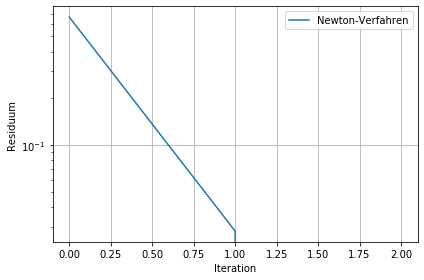

In [10]:
plt.semilogy(res, label='Newton-Verfahren')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Residuum')
plt.tight_layout()
plt.show()


Whatever weird values i throw at it, whatever error I try to nudge into the newton method,our algorithm just carries on and converges in two steps, meaning the convergence could be quadratic following that for any first order zeroes $$a$$ $$\log{|x_n-a|} \leq 2^n \log{K|x_0-a|} - \log{K}$$
also, it could come from the fact that I specifically chose a solution domain for our initial function $g(\theta_1,\theta_2)$ and only compute for those. Also I do not approximate the jacobian.

SO, let's entertain that my algorithm isn't super robust for the argument sake:
- i would need to be careful with the initial conditions, especially if they where suer close to the actual solutions or from the borders of the solutions space.

In our case, the robot can only have values $$ x,y \in [-3,3] \cup (-1,1)]$$

If we input out-of-bound values for x,y or for the thetas, the solution will not compute/converge.
If our initial thetas are too close or too far away from the solutions it could fuck-up as well, by accumulating errors that push the solutions out of bounds. 

For a robust procedure, I would always exactly compute the derivative/jacobian, choose initial conditions that are not too close from the border of the solutions space and/or from the actual solution.

We could also implement a dichotomic algorithm for the initial condition to test which ones are the more robust ones.




